In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 46.75
Ts = 0.38
K_rotation = L/Ts
K_translation = 1/Ts

W = np.identity(6)
V_c = np.identity(5)
V_nc = 20

# Filtre de Kalman

### Fonctions d'évolution

In [3]:
A = np.array([[1, 0, 0, Ts, 0, 0],
              [0, 1, 0, 0, Ts, 0],
              [0, 0, 1, 0, 0, Ts],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

A_trans = np.array([[1,Ts],
                    [0,1]])

C_trans = np.array([[0, 1]])

A_rot = np.array([[1,Ts],
                  [0,1]])

C_rot = np.array([[0, L]])

In [4]:
def Rotation_theta(theta):
    return np.array([[np.cos(theta), np.sin(theta)],
                     [-np.sin(theta), np.cos(theta)]])

def P_1_vers_0(theta):
    R_theta = Rotation_theta(theta)
    return np.block([[R_theta, np.zeros((2,4))],
                        [0,0,1,0,0,0],
                        [np.zeros((2,3)), R_theta, np.zeros((2,1))],
                        [np.zeros((1,6))]])

def P_0_vers_1(theta):
    return P_1_vers_0(theta).T

In [5]:
def g_c(z):
    theta = z[2]
    s_c=[z[0], # x
        z[1], # y
        z[2], # theta
        z[3]*np.cos(theta) + z[4]*np.sin(theta), # x_dot*cos(theta) + y_dot*sin(theta)
        L*z[5]] # L*theta_dot
    return np.array(s_c)

def g_nc(z, translation_or_rotation):
    if translation_or_rotation:
        return C_trans@z
    else:
        return C_rot@z

def grad_g_c(z):
    theta = z[2]
    x_dot, y_dot = z[3], z[4]
    grad = [[1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, -x_dot*np.sin(theta) + y_dot*np.cos(theta), np.cos(theta), np.sin(theta), 0],
            [0, 0, 0, 0, 0, L]]
    return np.array(grad)

def grad_g_nc(z, translation_or_rotation):
    if translation_or_rotation:
        return C_trans
    else:
        return C_rot

### Construction du vecteur observé

In [6]:
def constructing_s(V_left_measure, V_right_measure, camera_working=False,
                    x_measured=0, y_measured=0, theta_measured=0,                   
                    translation_or_rotation=True):
    if camera_working:
        s_c = np.array([x_measured,y_measured, theta_measured,
                        (V_left_measure + V_right_measure)/2 , (V_left_measure - V_right_measure)/2])
        return s_c
    elif translation_or_rotation:
        s_nc = (V_left_measure + V_right_measure)/2 # Mesure translation
    else:
        s_nc = (V_left_measure - V_right_measure)/2 # Mesure rotation
    return s_nc

### Etape de filtrage

In [7]:
def filtering_step(z_k_k_1, sigma_k_k_1, V_left_measure, V_right_measure, 
                   camera_working=False, x_measured=0, y_measured=0,
                    theta_measured=0, translation_or_rotation=True):
    ### Computing the variables that are dependant on the state of the camera
    s_k = constructing_s(V_left_measure, V_right_measure, camera_working,
                          x_measured, y_measured, theta_measured, 
                          translation_or_rotation)
    C_k = grad_g_c(z_k_k_1) if camera_working else grad_g_nc(z_k_k_1, translation_or_rotation)
    V = V_c if camera_working else V_nc
    # Changing the computation of the filter based on the state of the camera
    ### The camera is on so all the states are reconstructed
    if camera_working:
        g_k = g_c(z_k_k_1)
        ### The filtering step that can be rewritten without any problem
        L_k_k = sigma_k_k_1@C_k.T@np.linalg.inv(C_k@sigma_k_k_1@C_k.T + V)
        sigma_k_k = sigma_k_k_1 - L_k_k@C_k@sigma_k_k_1
        z_k_k = z_k_k_1 + L_k_k@(s_k-g_k)

    ### The thymio is translating so only the translation is reconstructed
    elif translation_or_rotation:
        ### Changing the frame of coordinates
            theta = z_k_k_1[2]
            z_1_k_k_1 = P_1_vers_0(theta) @ z_k_k_1
            sigma_1_k_k_1 = P_1_vers_0(theta) @ sigma_k_k_1 @ P_0_vers_1(theta)

            ### Creating a reduced state vector and covariance matrix
            z_1_red_k_k_1 = np.array([z_1_k_k_1[0], z_1_k_k_1[3]])  # x1  & x1_dot
            sigma_1_red_k_k_1 = np.array(
                [
                    [sigma_1_k_k_1[0, 0], sigma_1_k_k_1[0, 3]],
                    [sigma_1_k_k_1[3, 0], sigma_1_k_k_1[3, 3]],
                ]
            )

            g_k = g_nc(z_1_red_k_k_1, translation_or_rotation) 

            ### The filtering step can be computed for the reduced system
            L_red_k_k = (
                sigma_1_red_k_k_1
                @ C_k.T
                @ np.linalg.inv(C_k @ sigma_1_red_k_k_1 @ C_k.T + V)
            )
            sigma_1_red_k_k = sigma_1_red_k_k_1 - L_red_k_k @ C_k @ sigma_1_red_k_k_1
            z_1_red_k_k = z_1_red_k_k_1 + L_red_k_k @ (s_k - g_k)

            ### Putting back the reduced vector into the main one as well as the covariance matrix
            z_1_k_k = z_1_k_k_1
            z_1_k_k[0], z_1_k_k[3] = z_1_red_k_k[0], z_1_red_k_k[1]

            sigma_1_k_k = sigma_1_k_k_1
            sigma_1_k_k[0, 0], sigma_1_k_k[0, 3] = sigma_1_red_k_k[0, 0], sigma_1_red_k_k[0, 1]
            sigma_1_k_k[3, 0], sigma_1_k_k[3, 3] = sigma_1_red_k_k[1, 0], sigma_1_red_k_k[1, 1]

            ### Going back to the original frame
            z_k_k = P_0_vers_1(theta) @ z_1_k_k
            sigma_k_k = P_0_vers_1(theta) @ sigma_1_k_k @ P_1_vers_0(theta)

    ### The thyimio is turning so only the rotation is recontructed
    else:
        ### Extracting theta and theta_dot
        z_red_k_k_1 = np.array([z_k_k_1[2],
                                z_k_k_1[5]])
        
        sigma_red_k_k_1 = np.array([[sigma_k_k_1[2,2], sigma_k_k_1[2,5]],
                                    [sigma_k_k_1[5,2], sigma_k_k_1[5,5]]])
        
        g_k = g_nc(z_red_k_k_1, translation_or_rotation)
        ### The filtering step can be computed for the reduced system
        L_red_k_k = sigma_red_k_k_1@C_k.T@np.linalg.inv(C_k@sigma_red_k_k_1@C_k.T + V)
        sigma_red_k_k = sigma_red_k_k_1 - L_red_k_k@C_k@sigma_red_k_k_1
        z_red_k_k = z_red_k_k_1 + L_red_k_k@(s_k-g_k)

        z_k_k = z_k_k_1
        z_k_k[2], z_k_k[5] = z_red_k_k[0], z_red_k_k[1]

        sigma_k_k = sigma_k_k_1
        sigma_k_k[2,2], sigma_k_k[2,5] = sigma_red_k_k[0,0], sigma_red_k_k[0,1]
        sigma_k_k[5,2], sigma_k_k[5,5] = sigma_red_k_k[1,0], sigma_red_k_k[1,1]
        

    return z_k_k, sigma_k_k

### Etape de Prédiction

In [8]:
def prediction_step(z_k_k, sigma_k_k):
    z_k_1_k = A@z_k_k
    sigma_k_1_k = A@sigma_k_k@A.T + W
    return z_k_1_k, sigma_k_1_k

### Génération d'un vecteur d'état

In [9]:
def generating_z_prediction(z_mean, z_cov_matrix):
    return np.random.multivariate_normal(z_mean, z_cov_matrix)

# Simulation

In [10]:
omega = 1
Vitesse = omega*L

z_0 = np.array([0,0,0,0,0,omega])
sigma_0 = 0.1*np.identity(6)

N = 100 # Durée expérience

z=np.zeros((6,N))
z[:,0] = z_0
for i in range(1,N):
    z[:,i] = np.array([0,0,Ts*i*omega,0,0,omega])

In [11]:
z_filtered = []
sigma_filtered = []

z_predicted = [z_0]
sigma_predicted = [sigma_0]

for i in range(N):
    Vitesse_left = Vitesse + np.random.normal(scale=V_c)
    Vitesse_right = -Vitesse + np.random.normal(scale=V_c)
    
    z_k_k, sigma_k_k= filtering_step(z_k_k_1 = z_predicted[-1], 
                                    sigma_k_k_1 = sigma_predicted[-1], 
                                    V_left_measure = Vitesse_left[0,0], 
                                    V_right_measure = Vitesse_right[0,0], 
                                    camera_working=False,
                                    translation_or_rotation=False)
    
    z_filtered.append(z_k_k)
    sigma_filtered.append(sigma_k_k)

    z_k_1_k, sigma_k_1_k = prediction_step(z_k_k, sigma_k_k)
    z_predicted.append(z_k_1_k)
    sigma_predicted.append(sigma_k_1_k)

In [12]:
z_filtered_array = np.array(z_filtered)
z_filtered_array = z_filtered_array.T
#z_filtered_array[0,:]

In [13]:
# for i in range(N):
#     z_filtered_array[:,i] = generating_z_prediction(z_filtered_array[:,i], sigma_filtered[i]) 

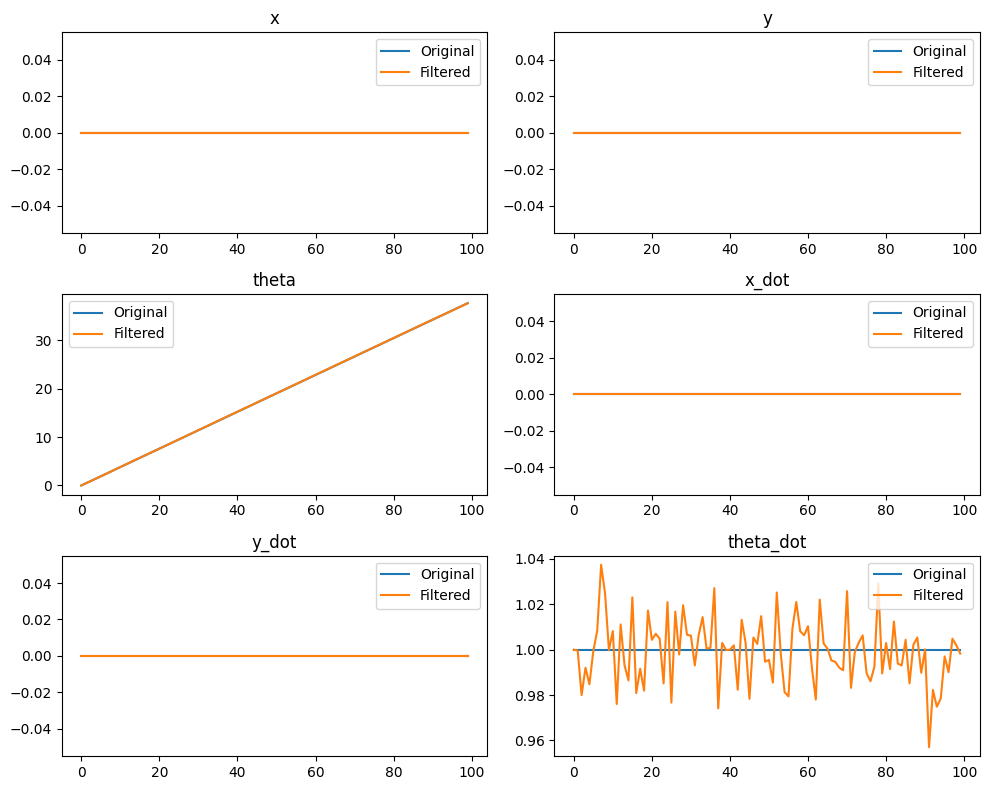

In [14]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    axes[i].plot(z[i, :], label='Original')
    axes[i].plot(z_filtered_array[i, :], label='Filtered')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
z_predicted_array = np.array(z_predicted)
z_predicted_array = z_predicted_array.T

In [16]:
# for i in range(1,N+1):
#     z_predicted_array[:,i] = generating_z_prediction(z_predicted_array[:,i], sigma_predicted[i]) 

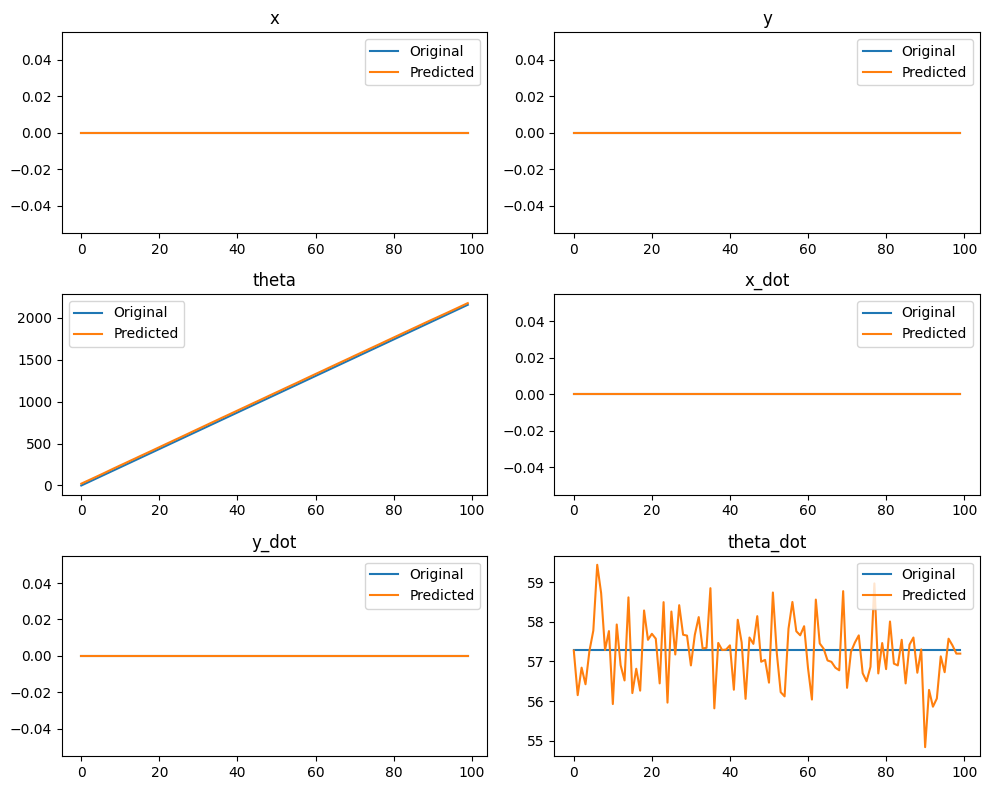

In [17]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    gamma = 1
    if i == 2 or i == 5:
        gamma = 180/np.pi
    axes[i].plot(gamma*z[i, :], label='Original')
    axes[i].plot(gamma*z_predicted_array[i, 1:], label='Predicted')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Test conditions réelles

In [1]:
import thymio_KCT as th
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Setting up the origin and the kalman filter
current_pos = np.array([0,0,0])
current_speed = np.array([0,0,0])
z_predicted = np.array([0,0,0,0,0,0]) #kalman_state
sigma_predicted = np.diag([0,0,0,0,0,0])

### Goal pos
goal_pos = np.array([300,0])


print("Open thymio")
thymio = th.Thymio()
await thymio.initiateLock()
print("Thymio opened")

Open thymio
Thymio opened


In [ ]:
### Data storage for plotting
xdata, ydata, thetadata, Vleftdata, Vrightdata = [], [], [], [], []
iteration_times = []
vars_towait = ['prox.horizontal','motor.right.speed','motor.left.speed','motor.right.target','motor.right.target']
    
while True:
    start_time = time.time()  # Capture start time
    thymio.wait_for_variables(vars_towait)

    if thymio.robot_close_waypoint(current_pos[:2], goal_pos[0], goal_pos[1]):
        print("Goal reached")
        thymio.set_multiple_variables({"motor.left.target":[0],"motor.right.target":[0]})
        break
    
    
    Vleft = thymio.getSpeedL()
    Vright = thymio.getSpeedR()

    translation_or_rotation = thymio.navigate(current_pos, goal_pos)
    current_pos = z_predicted[:3] # Is used for the controller

    xdata.append(current_pos[0])
    ydata.append(current_pos[1])
    thetadata.append(current_pos[2])
    Vleftdata.append(Vleft)
    Vrightdata.append(Vright)

    z_filtered, sigma_filtered= thymio.filtering_step(z_k_k_1 = z_predicted, 
                                    sigma_k_k_1 = sigma_predicted, 
                                    V_left_measure = Vleft, 
                                    V_right_measure = Vright, 
                                    camera_working=False,
                                    translation_or_rotation = translation_or_rotation)
    
    z_predicted, sigma_predicted = thymio.prediction_step(z_filtered, sigma_filtered)

    obstacle,detected = thymio.getObstaclePosition()
    if detected:
        print("Obstacle detected")
        
    

    end_time = time.time()  # Capture end time
    iteration_time = end_time - start_time  # Compute iteration time
    iteration_times.append(iteration_time)  # Store iteration time
    print(f"Iteration time: {iteration_time:.6f} seconds")  # Print iteration time


Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.513762 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.307070 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.308234 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.305338 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.308397 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.312148 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.306674 seconds
Is the goal reached ?
False
{'motor.left.target': [225], 'motor.right.target': [225]}
Iteration time: 0.308216 seconds
Is the goal reached ?
False
{'motor.left.target'

In [4]:
thymio.set_multiple_variables({"motor.left.target":[0],"motor.right.target":[0]})

{'motor.left.target': [0], 'motor.right.target': [0]}


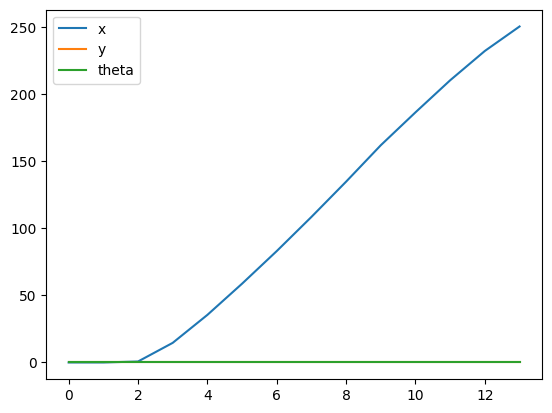

In [4]:
plt.plot(xdata, label='x')
plt.plot(ydata, label='y')
plt.plot(thetadata, label='theta')
plt.legend()

In [5]:
xdata

[0,
 0.0,
 0.7298657888888889,
 14.63100189111111,
 35.490479762905984,
 58.75866716388637,
 83.08710624278774,
 108.54927788751831,
 134.86089355768226,
 162.01744846089662,
 186.54736035773948,
 210.4556684522824,
 232.3222175608915,
 250.56359852389596]

In [ ]:
Vleftdata = np.array(Vleftdata)
Vrightdata = np.array(Vrightdata)

In [ ]:
plt.plot(Vleftdata, label="V left")
plt.plot(Vrightdata, label="V right")
plt.legend()

In [ ]:
plt.plot((Vleftdata+Vrightdata)/2, label = "translation")
plt.plot((Vleftdata-Vrightdata)/2, label = "rotation")
plt.legend()

In [ ]:
V = (Vrightdata + Vleftdata)/2
Distance = [0]

for i in range(len(V)-1):
    Distance.append(Distance[-1] + Ts*V[i])

print(Distance)
plt.plot(Distance, label="int")
plt.plot(xdata, label="Kalman")
plt.legend()